**Программа межлабораторного контроля качества**

МЛПП - элемент комплексной сервисно-методической поддержки клиентов АО «Вектор-Бест», направленной на повышение степени лояльности клиентов к компании, удовлетворенности от работы с нашей биохимической продукцией, в конечном счете – на увеличение объема продаж.

Благодаря широкой сети представительств «Вектор-Бест» в России в ней принимают участие КДЛ из всех федеральных округов в общей сложности **более 700 медицинских лабораторий.**
С 2017 по 2021 г. проведено 11 циклов МЛПП.

Цель: **предотвращение оттока клиентов путем предсказания и своевременного выявления проблем контроля качества**, до того как они станут критичными и вызовут недовольство клиентов. 
Для этого после каждого цикла программы **исследовались данные по оттоку участников**.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,r2_score, roc_auc_score, recall_score,confusion_matrix
import os
import matplotlib.pyplot as plt
import shap

Процедура визуализации интерпритации моделей.
Строим шапы и депенденсы для нашей выборки.

In [2]:
def get_shap(X, target, rank_range=5):
    """
    Процедура визуализации интерпритации моделей.
    Строим шапы и депенденсы для нашей выборки.
    """
    fig, ax = plt.subplots(1, figsize=(10, 15))
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False)
    fig, ax = plt.subplots(1, figsize=(10, 15))
    shap.summary_plot(shap_values, X, plot_type="bar")
    for i in range(0,rank_range):
        shap.dependence_plot('rank('+str(i)+')', shap_values, X, show=False)
        


Загрузим результаты исследований по **30 биохимическим маркерам нормального и патологического уровней** и данным, полученным на основе ответов на вопросы анкеты.

In [2]:
# Load data
df = pd.read_csv('MLPP_ML_2021.csv')
df

,ID,Name,Region,Churn,Z_score,Pribor,VKK,Count_results,cycle,True_results,Calibration,EQAS,FSVOK
0,Б1,"ГБУЗ ""Самарская областная клиническая больница""",Приволжский ФО,1,1.630813,ручной_анализ,0,11,6,36,1,1,1
1,Б2_1,"ГБУЗ ""Консультативно-диагностический центр №85...",Приволжский ФО,1,1.614549,полуавтомат,1,18,4,30,1,1,1
2,Б2_2,"ГБУЗ ""Консультативно-диагностический центр №85...",Приволжский ФО,1,1.228905,полуавтомат,1,9,6,45,1,0,0
3,Б3,"ГБУЗ ""Городская поликлиника №91""",Приволжский ФО,1,1.310005,ручной_анализ,0,23,8,41,0,1,1
4,Б4_1,ГБУЗ ГБ №26 Анализатор Taurus u21161,Приволжский ФО,1,1.172678,полуавтомат,0,15,4,23,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,С79,"ОГБУЗ ""Черемховская городская больница №1""",Южный ФО,0,0.829153,полуавтомат,0,23,8,82,1,0,0
559,С80,ФГБУЗ Центральная медико-санитарная часть №28 ...,Южный ФО,0,1.030531,автомат_анализатор,1,30,8,49,1,1,1
560,С81,ОГБУЗ «Областная больница №2»,Южный ФО,0,0.908902,полуавтомат,1,34,3,48,1,1,1
561,С82,Тюменская больница ФГБУЗ «Западно-Сибирский ме...,Уральский ФО,0,1.239600,ручной_анализ,1,23,7,42,1,1,0


**Параметры, по порядку, отвечают за:**

ID - идентификационный номер лаборатории

Name - название клинико-диагностической лаборатории

Region - регион России

Churn - отток участвующих лабораторий в программе по контролю качества исследований биохимических маркеров

Z_score - среднее значение индекса SDI (как среднее для всех показателей)

Pribor - тип используемого оборудования (автоматический анализатор, полуавтоматический анализатор, ручной анализ)

VKK - наличие внутрилабораторного контроля качества

Count_results - количество исследуемых биохимических маркеров

cycle - число циклов программы, в которых приняли участие

True_results - доля правильных результатов (%)

Calibration - наличие калибратора в системе

EQAS - участие в международной системе контроля качества EQAS

FSVOK - участие в федеральной российской системе контроля качества FSVOK

**Строим sns.pairplot, чтобы показать соотношения между всеми парами переменных.**

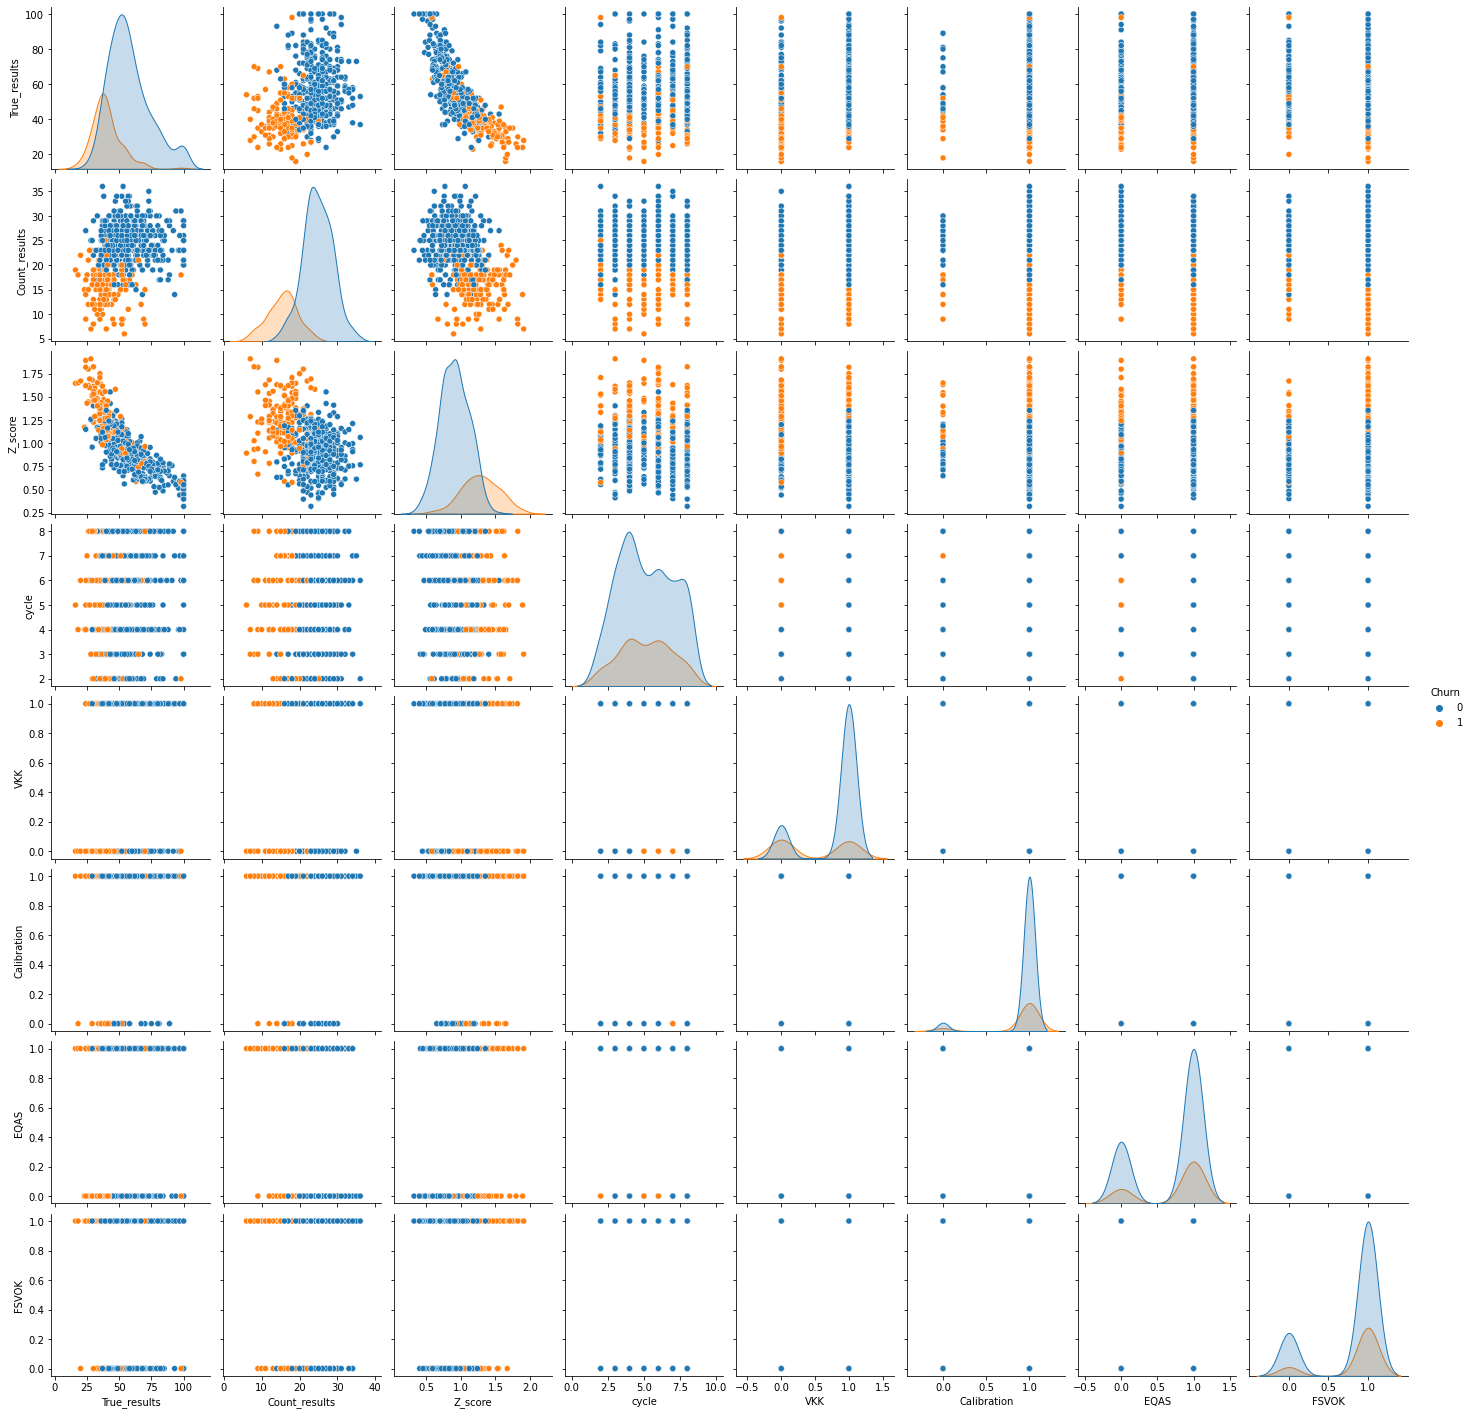

In [4]:
# Разделяем переменный на числовые и категориальные, Выделяем таргет. 
# Строим попарные графики, чтобы увидеть общую картину по данным
num_col = [ 'True_results', 'Count_results', 'Z_score', 'cycle']
cat_col = ['Region','Pribor','VKK','Calibration', 'EQAS', 'FSVOK']
target = 'Churn'
sns.pairplot(df[num_col + cat_col + [target]], hue=target)

Мы рассмотрим случай бинарной классификации, модель будет предсказывать вероятность оттока лаборатории из программы (класс 1).
Исследуем, по каким причинам медицинские лаборатории перестали принимать участие в программе внешней оценки качества.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Churn
Train count / churn 422 / 102
Test count / churn 141 / 34
Matrix 
 [[105   2]
 [  2  32]]
f1_score 0.9411764705882353
accuracy_score 0.9716312056737588
roc_auc_score 0.9612424409015943
recall_score 0.9411764705882353
      Feature Id  Importances
0  Count_results    36.233171
1         Pribor    26.293024
2        Z_score    13.833265
3   True_results     9.210000
4         Region     7.925224
5          cycle     4.430522
6            VKK     1.664577
7          FSVOK     0.395610
8    Calibration     0.014608
9           EQAS     0.000000


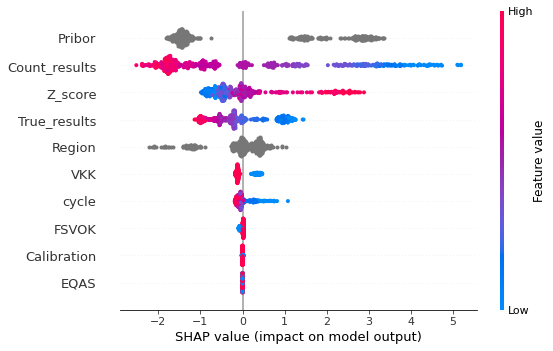

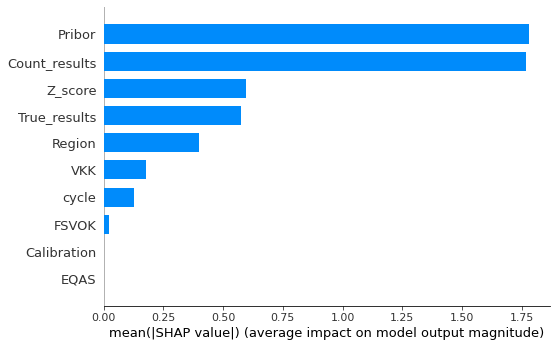

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


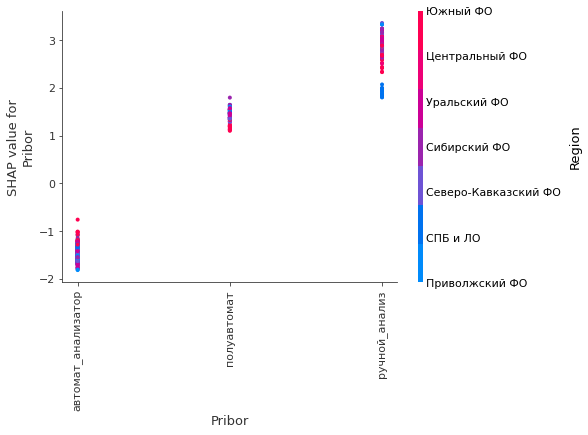

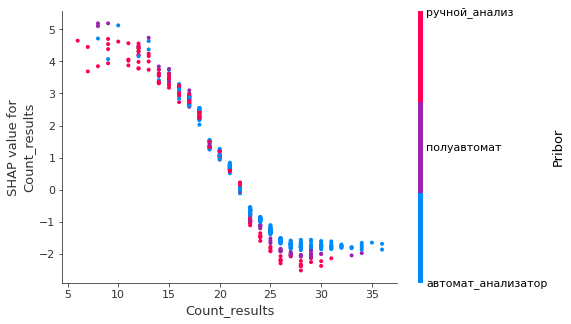

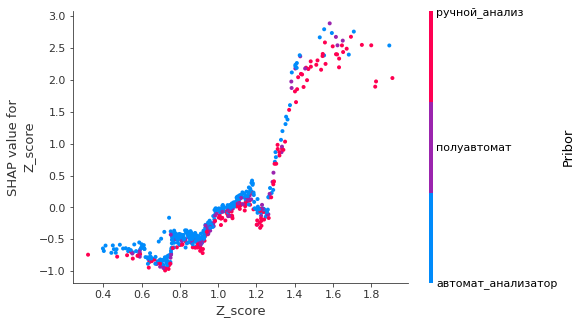

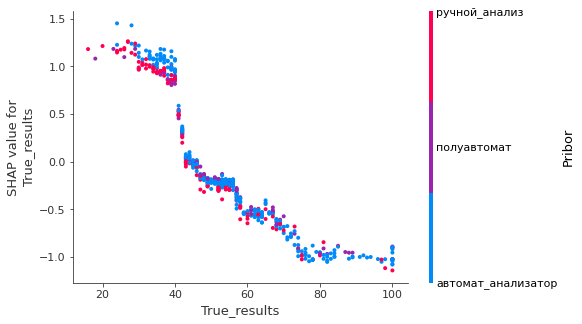

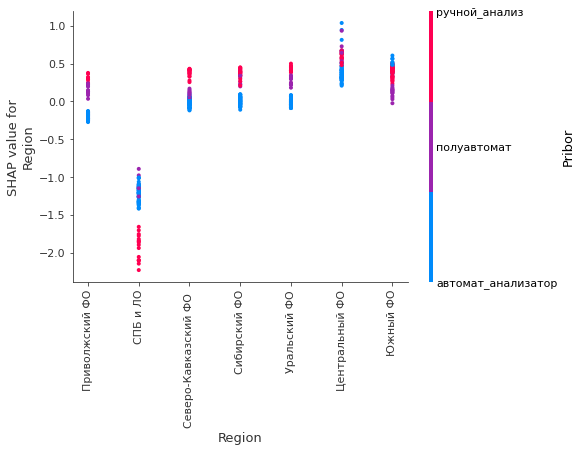

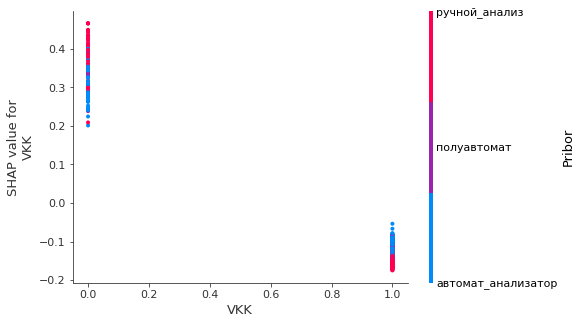

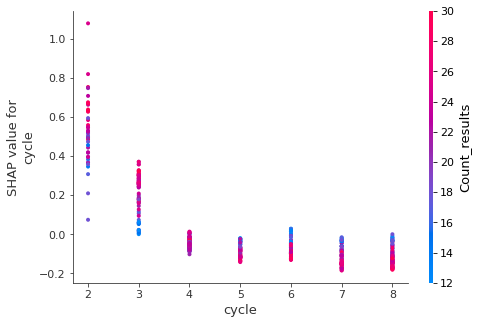

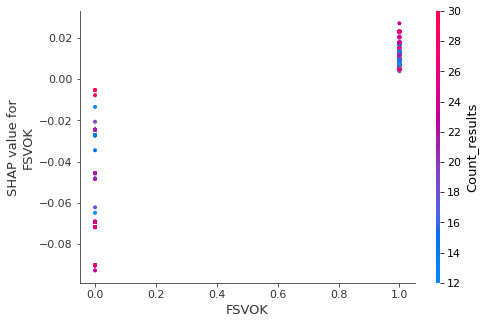

In [5]:
# Сторим модель классификатора 
# Поскольку у нас много категориальных переменных, то используем CatBoost.

# Разбиваем данные на тест и трейн. Важно, т.к. у нас дисбаланс классов, то делаем stratify
X_train, X_test,y_train, y_test = train_test_split(df[num_col + cat_col], df[target],stratify = df[target] )
# Определяем классификатор, обязательно контролируем веса классов
clf = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=3,cat_features = cat_col, class_weights=[1,round(1/df[target].mean(), 1)])
# Во время обучения смотрим на изменение ошибки на тесте. 
clf.fit(X_train, y_train
                  ,eval_set = Pool(X_test, y_test, cat_features = cat_col)
                  ,plot=True
                  ,verbose = False
                  ,use_best_model=True)

y_pred_test = clf.predict(X_test)
# Собираем метрики
line = target + '\n'
line += f'Train count / churn { y_train.count()} / { y_train.sum()}\n'
line += f'Test count / churn { y_test.count()} / { y_test.sum()}\n'
line += f'Matrix \n {confusion_matrix(y_pred_test,y_test)}\n'
line += f"f1_score {f1_score(y_pred_test,y_test)}\n"
line+= f"accuracy_score {accuracy_score(y_pred_test,y_test)}\n" 
line += f"roc_auc_score {roc_auc_score(y_test, y_pred_test)}\n"
line +=f"recall_score {recall_score(y_test, y_pred_test)}\n" 
line += f'{clf.get_feature_importance(prettified=True)}'
print(line)
get_shap(df[num_col + cat_col], target, rank_range=8)

**Выводы:**

Удалось с хорошей точностью (f1_score=0.94) классифицировать отток участвующих лабораторий.

Основной отток связан с количеством исполняемых тестов (чем меньше тестов, тем больше вероятность оттока). Это может быть объяснено плохой организацией процесса в лаборатории, невозможности проведения большого разнообразия тестов.

Полученные данные позволяют определить некоторые направления дальнейшей работы и условия, способствующими повышению точности результатов и их сопоставимости в лабораториях, использующих наборы Вектор-Бест для биохимического анализа:
1) оснащение лабораторий автоматическими анализаторами, составляющими систему с нашими наборами реагентов, их сервисно-методическое сопровождение;
2) наличие в лабораториях эффективной системы контроля качества на аналитическом этапе (с нашей стороны – помощь в организации такой системы);
3) замена биохимических мультикалибраторов сторонних производителей, пока еще широко использующихся в лабораториях, нашей продукцией (Мультикалибратор-СЭ, Мультикалибратор-Ф);
4) продвижение наборов реагентов, основанных на более точных методов анализа.

Возможности анализатора закономерно влияют на качество исследований, но не всегда только они являются ограничивающим фактором. Резервы улучшения заложены в использовании дифференцированного подхода к контролю качества на основе **сигмаметрии**. В лабораториях, где **требуемый уровень точности** не достигается, целесообразно использовать более эффективные контрольные процедуры, усилить нестатистические формы контроля (оптимизация технического обслуживания оборудования, условий поставки и хранения реагентов и калибраторов, подготовки воды, дополнительное обучение персонала и др.)

К сожалению, еще немало лабораторий, которым пока не удается добиться устойчивого качества результатов. Согласно анкетному опросу участников программы, 30 % из ответивших не проводят внутрилабораторный контроль или подменяют его периодической проверкой попадания результатов измерений контрольного материала в допустимый диапазон, указанный производителем. В программах внешней оценки качества не участвуют 22 % лабораторий. Очевидно, что достижение и поддержание необходимого уровня точности результатов невозможно без систематического контроля качества на аналитическом этапе. Для лабораторий, использующих наборы реагентов «Вектор-Бест», дополнительным инструментом в повышении эффективности этой работы может служить Межлабораторная программа-практикум.
